# Установка и импорт библиотек

In [ ]:
!pip install "gymnasium[atari]"  autorom[accept-rom-license] install moviepy

In [ ]:
#
import gymnasium as gym
import ale_py

import torch
import numpy as np
import matplotlib.pyplot as plt
# Для вывода видео
from moviepy.editor import *
from IPython.display import HTML
from base64 import b64encode

# Настройка окружения для обучеия с подкреплением

In [ ]:
env = gym.make('ALE/SpaceInvaders-v5', render_mode="rgb_array")
n_state = env.observation_space.shape[0]*env.observation_space.shape[1]*3
n_action = env.action_space.n
env = gym.wrappers.RecordVideo(
    env,
    episode_trigger=lambda num: True,
    video_folder="saved-video-folder",
    name_prefix="video-",
    # disable_logger=True
)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/saved-video-folder folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


# Функция прохождения эпизода

In [ ]:
def run_episode(env, weight):
    state = env.reset()[0]
    grads = []
    total_reward = 0
    while True:
        # Преобразование состояния в тензор PyTorch
        state = torch.from_numpy(state).float()/255 # нормализуем тензор до (0..1)
        state = state.view(-1) # изменяем форму эквивалентно state = torch.reshape(state, (-1,))

        # Вычисляем логиты с использованием текущего состояния и весов.
        z = torch.matmul(state, weight)

        # Применяем функцию Softmax к логитам, чтобы получить вероятности действий
        probs = torch.nn.Softmax(dim= 0)(z)

        # Выбор действия на основе вероятности v.1
        # Выбираем индекс действия с самой большой вероятностью

        action = torch.argmax(probs).item()

        # Выбор действия v.2
        # action = torch.multinomial(probs, num_samples=1).item()

        # Вычисляем производную Softmax (матрицы Якоби)
        d_softmax = torch.diag(probs) - probs.view(-1, 1) * probs

        # Вычисляем производную логарифма вероятности выбранного действия
        d_log = d_softmax[action] / probs[action]

        # Вычисляем градиент весов относительно выбранного действия
        grad = state.view(-1, 1) * d_log

        # Добавляем градиент в список градиентов
        grads.append(grad)

        # Выполняем выбранное действие в среде, получаем новое состояние,
        # вознаграждение и флаг завершения эпизода
        state, reward, done, truncated, info = env.step(action)



        # Добавляем полученное вознаграждение к общему вознаграждению
        total_reward += reward
        if done or truncated:
            break
    return total_reward, grads

# Параметры

In [ ]:
n_state = env.observation_space.shape[0]*env.observation_space.shape[1]*3
n_action = env.action_space.n
n_episode = 5
weight = torch.rand(n_state, n_action)
total_rewards = []
learning_rate = 0.001

# Обучение

In [ ]:
for episode in range(n_episode):

    total_reward, gradients = run_episode(env, weight)

    print('Эпизод {}: {}'.format(episode + 1, total_reward))
    for i, gradient in enumerate(gradients):
        weight += learning_rate * gradient * (total_reward - i)
    total_rewards.append(total_reward)
env.close()

Эпизод 1: 220.0
Эпизод 2: 390.0
Эпизод 3: 285.0
Эпизод 4: 240.0
Эпизод 5: 160.0


In [ ]:
print('Среднее полное вознаграждение в {} эпизодах: {}'.format(n_episode, sum(total_rewards) / n_episode))

Среднее полное вознаграждение в 5 эпизодах: 259.0


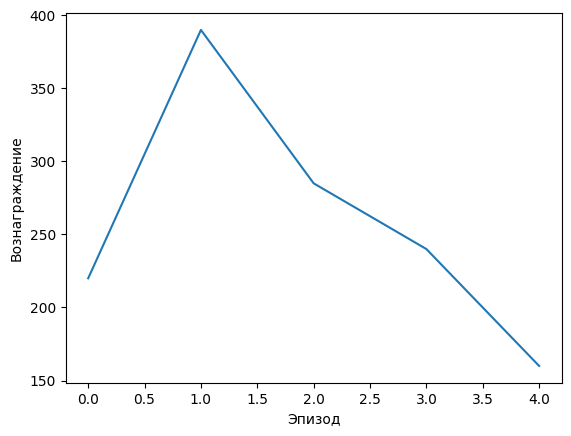

In [ ]:
plt.plot(total_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Вознаграждение')
plt.show()

# Создание видео

In [ ]:
VIDEO_DIR = './saved-video-folder/'
FILE_NAME = "video--episode-{:d}.mp4"

In [ ]:
max_index = []

for i in range(3):
  max_value = max(total_rewards)
  idx = total_rewards.index(max_value)
  max_index.append(idx)
  total_rewards[idx]= 0

[1, 2, 3]


In [ ]:
clips = [VideoFileClip(VIDEO_DIR+FILE_NAME.format(i)) for i in max_index]
final_clip = concatenate_videoclips(clips, method="compose")
final_clip.write_videofile('res.mp4')

Moviepy - Building video res.mp4.
Moviepy - Writing video res.mp4



t:  36%|███▋      | 1001/2759 [00:00<00:00, 1988.27it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./saved-video-folder/video--episode-1.mp4, 100800 bytes wanted but 0 bytes read,at frame 1058/1059, at time 35.27/35.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                                  

Moviepy - Done !
Moviepy - video ready res.mp4


# Вывод

In [ ]:
video_file = open('res.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(video_file).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Алгоритм градиента стратегии плохо подходит для данной задачи, т.к. награда выдается за уничтожение "целей" и не учитываается другие аспекты игры. Агент старается максимизировать награду путем "уничтожения" захатчиков что приводит к быстрому проигрышу т.к. не пытается уворачиваться от снарядов. Для решения данной проблемы можно попробывать ввести максимальное количество возможно полученых очков и штрафовать за получение урона, или ввести систему штрафов за потери "жизней".